In [36]:
import matplotlib.pyplot as plt
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [37]:
# Visualization
import matplotlib.font_manager as fm

# 나눔 폰트 경로 설정
font_path = '/Library/Fonts/NanumGothic.ttf'

# 나눔 폰트 설정
fe = fm.FontEntry(
    fname=font_path,  # ttf 파일이 저장되어 있는 경로
    name='NanumGothic'  # 이 폰트의 원하는 이름 설정
)
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})  # 폰트 설정
plt.rc('font', family='NanumGothic')

In [38]:
train_data = pd.read_csv('./data/train_model_1.csv')
test_data = pd.read_csv('./data/test_model_1.csv')

In [39]:
display(test_data.shape)

(9272, 40)

In [40]:
import re
# 특수 문자 제거 또는 대체 함수
def clean_column_name(name):
   return re.sub(r'[^a-zA-Z0-9가-힣]', '_', name)

# 모든 열 이름을 정리
train_data.columns = [clean_column_name(col) for col in train_data.columns]
test_data.columns = [clean_column_name(col) for col in test_data.columns]

In [41]:
train_data.columns

Index(['아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k_단지분류_아파트_주상복합등등_',
       'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식', 'k_전체동수', 'k_전체세대수',
       'k_건설사_시공사_', 'k_시행사', 'k_연면적', 'k_주거전용면적', 'k_전용면적별세대현황_60_이하_',
       'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', 'k_135_초과', '건축면적', '주차대수',
       '기타_의무_임대_임의_1_2_3_4', '좌표X', '좌표Y', 'target', 'distance_score', '구',
       '동', '계약연도', '계약월', 'address', '신축여부', '이자율', '시공능력평가_상위여부', '대장아파트_거리',
       '거래유형', '급지'],
      dtype='object')

In [34]:
result = test_data.groupby(['급지', '거래유형']).size().unstack(fill_value=0)
result_percentage = result.div(result.sum(axis=1), axis=0) * 100

# 소수점 둘째 자리까지 반올림하여 보기 좋게 출력
print(result_percentage.round(2))

거래유형    중개거래    직거래
급지                 
G1     97.61   2.39
G10   100.00   0.00
G2     97.49   2.51
G3     96.65   3.35
G4     96.30   3.70
G5     97.08   2.92
G6     96.41   3.59
G7     96.21   3.79
G8     94.53   5.47
G9     86.21  13.79


In [19]:
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in train_data.columns:
    if pd.api.types.is_numeric_dtype(train_data[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k_전체동수', 'k_전체세대수', 'k_연면적', 'k_주거전용면적', 'k_전용면적별세대현황_60_이하_', 'k_전용면적별세대현황_60__85_이하_', 'k_85__135_이하', 'k_135_초과', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'distance_score', '계약연도', '계약월', '신축여부', '이자율', '시공능력평가_상위여부', '대장아파트_거리']
범주형 변수: ['아파트명', '도로명', 'k_단지분류_아파트_주상복합등등_', 'k_세대타입_분양형태_', 'k_관리방식', 'k_복도유형', 'k_난방방식', 'k_건설사_시공사_', 'k_시행사', '기타_의무_임대_임의_1_2_3_4', '구', '동', 'address', '거래유형', '급지']


In [42]:
# train과 test 데이터를 합쳐서 하나의 데이터프레임으로 만듭니다.
combined_data = pd.concat([train_data, test_data], axis=0)

#전용면적 로그 변환
combined_data['전용면적'] = np.log1p(combined_data['전용면적'])

# 각 범주형 변수에 대해 LabelEncoder를 적용합니다.
label_encoders = {}

for col in categorical_columns_v2:
    lbl = LabelEncoder()
    combined_data[col] = combined_data[col].astype(str)  # 데이터 타입을 문자열로 변환
    combined_data[col] = lbl.fit_transform(combined_data[col])
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블인코더를 저장해둡니다.

# 인코딩된 데이터를 다시 train과 test 데이터로 나눕니다.
train_data_encoded = combined_data.iloc[:len(train_data)]
test_data_encoded = combined_data.iloc[len(train_data):]

In [43]:
# CSV 파일 불러오기
importance_df = pd.read_csv('feature_importances.csv')

# 중요도 순으로 정렬
feature_importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

print("Feature Importance DataFrame:")
print(feature_importance_df)

Feature Importance DataFrame:
                   feature    importance
0                     계약년월  1.045655e+09
1                     전용면적  9.756646e+08
2                       급지  6.113884e+08
3                     거래유형  2.695819e+08
4                     건축년도  1.695819e+08
5                      좌표Y  1.136631e+08
6                      좌표X  6.300580e+07
7                  address  5.447845e+07
8                        구  2.346532e+07
9                 대장아파트_거리  2.164844e+07
10                       층  1.891177e+07
11                   k_연면적  1.570995e+07
12                  k_전체동수  1.222237e+07
13                       동  1.209701e+07
14                    주차대수  1.160945e+07
15      k_단지분류_아파트_주상복합등등_  1.124049e+07
16                  k_난방방식  1.095110e+07
17                k_주거전용면적  1.078178e+07
18          distance_score  8.790410e+06
19                     도로명  7.312892e+06
20                    아파트명  6.965256e+06
21                     이자율  5.912753e+06
22                 k_전체세대수 

In [44]:
sorted_features = feature_importance_df['feature'].tolist()

#display(best_feature_count)
best_feature_count = 17 # 적용할 파라미터의 수
best_features = sorted_features[:best_feature_count]
display(best_features)

['계약년월',
 '전용면적',
 '급지',
 '거래유형',
 '건축년도',
 '좌표Y',
 '좌표X',
 'address',
 '구',
 '대장아파트_거리',
 '층',
 'k_연면적',
 'k_전체동수',
 '동',
 '주차대수',
 'k_단지분류_아파트_주상복합등등_',
 'k_난방방식']

# lightGBM Modeling
- 급지별로 계산

In [46]:
import wandb
from datetime import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# target 값에 log 변환 적용
train_data_encoded['log_target'] = np.log1p(train_data_encoded['target'])

districts = train_data_encoded['급지'].unique()

# 최종 예측 결과를 저장할 데이터프레임
final_predictions = pd.DataFrame()
feature_importances = pd.DataFrame()

for district in districts:
    print(f"Processing district: {district}")
    
    # WandB 초기화
    run_name = f"lightGBM_{district}_{datetime.now().strftime('%m%d_%H%M')}"
    wandb.init(
        project="re_price_prediction",
        group="lightGBM final",
        name=run_name,
        reinit=True,
        config={
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'n_estimators': 100000,
            'learning_rate': 0.0102,
            'num_leaves': 107,
            'max_depth': 10,
            'min_child_samples': 8,
            'subsample': 0.5668227534307944,
            'colsample_bytree': 0.6033862727269486,
            'reg_alpha': 2.5906244698002496e-06,
            'reg_lambda': 2.979573198070953e-05,
            'force_col_wise': True,
        }
    )
    
    # 현재 구의 데이터만 선택
    district_data = train_data_encoded[train_data_encoded['급지'] == district]
    
    # 특성과 타겟 분리
    X = district_data.drop(['target', 'log_target', '급지'], axis=1)
    y = district_data['log_target']
    
    # 학습 및 검증 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # LightGBM 모델 정의
    params = dict(wandb.config) 
    gbm = lgb.LGBMRegressor(**params)
    
    # wandb에 로깅하는 콜백 함수
    def log_to_wandb(env):
        for data_name, eval_name, eval_result, _ in env.evaluation_result_list:
            metric_name = f"{data_name}_{eval_name}"
            wandb.log({metric_name: eval_result})
    
    # 모델 학습
    gbm.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric='rmse',
        categorical_feature="auto",
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=50),
            log_to_wandb
        ]
    )
    
    print(f"Best iteration: {gbm.best_iteration_}")
    print(f"Best score: {gbm.best_score_['valid_1']['rmse']}")
    
    # wandb에 최종 점수 로깅
    wandb.log({"final_best_score": gbm.best_score_['valid_1']['rmse']})

    # 피처 중요도 저장
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': gbm.feature_importances_,
        'district': district
    })
    feature_importances = pd.concat([feature_importances, importance_df], axis=0) 
    
    # 테스트 데이터에 대한 예측
    X_test = test_data_encoded[test_data_encoded['급지'] == district].drop(['급지', 'target'], axis=1)

    if not X_test.empty:
        log_district_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
        
        # log 예측값을 원래 스케일로 변환
        district_pred = np.expm1(log_district_pred)

        # 예측 결과를 데이터프레임에 저장
        district_results = pd.DataFrame({
            'id': X_test.index,
            'target': district_pred.astype(int)
        })
        final_predictions = pd.concat([final_predictions, district_results])
    
        # 테스트 데이터 개수를 wandb에 로깅
        wandb.log({"test_data_count": len(X_test)})
    else:
        print(f"급지 계산완료: {district}")
        wandb.log({"test_data_count": 0})
    
    # wandb 실행 종료
    wandb.finish()

Processing district: 0


[LightGBM] [Info] Total Bins 5191
[LightGBM] [Info] Number of data points in the train set: 168928, number of used features: 38
[LightGBM] [Info] Start training from score 11.427333
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.381981	valid_1's rmse: 0.382004
[100]	training's rmse: 0.272744	valid_1's rmse: 0.273682
[150]	training's rmse: 0.20652	valid_1's rmse: 0.208313
[200]	training's rmse: 0.164959	valid_1's rmse: 0.167412
[250]	training's rmse: 0.140007	valid_1's rmse: 0.143031
[300]	training's rmse: 0.123932	valid_1's rmse: 0.127425
[350]	training's rmse: 0.113431	valid_1's rmse: 0.117335
[400]	training's rmse: 0.106225	valid_1's rmse: 0.110516
[450]	training's rmse: 0.100948	valid_1's rmse: 0.105639
[500]	training's rmse: 0.09699	valid_1's rmse: 0.10204
[550]	training's rmse: 0.0938717	valid_1's rmse: 0.0992827
[600]	training's rmse: 0.0913413	valid_1's rmse: 0.0971437
[650]	training's rmse: 0.0892699	valid_1's rmse: 0.0954498
[700]	training

final_best_score,▁
test_data_count,▁
training_rmse,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.0806
test_data_count,2756
training_rmse,0.05415
valid_1_rmse,0.0806


Processing district: 2


[LightGBM] [Info] Total Bins 4970
[LightGBM] [Info] Number of data points in the train set: 75646, number of used features: 38
[LightGBM] [Info] Start training from score 11.092492
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.327686	valid_1's rmse: 0.327615
[100]	training's rmse: 0.223689	valid_1's rmse: 0.223555
[150]	training's rmse: 0.161481	valid_1's rmse: 0.161348
[200]	training's rmse: 0.123113	valid_1's rmse: 0.123018
[250]	training's rmse: 0.101504	valid_1's rmse: 0.10147
[300]	training's rmse: 0.0884854	valid_1's rmse: 0.0885904
[350]	training's rmse: 0.0805912	valid_1's rmse: 0.0808294
[400]	training's rmse: 0.0754153	valid_1's rmse: 0.075787
[450]	training's rmse: 0.0718251	valid_1's rmse: 0.0723355
[500]	training's rmse: 0.0690648	valid_1's rmse: 0.0697733
[550]	training's rmse: 0.0670188	valid_1's rmse: 0.0679896
[600]	training's rmse: 0.0653759	valid_1's rmse: 0.0666005
[650]	training's rmse: 0.0639383	valid_1's rmse: 0.0654426
[700

final_best_score,▁
test_data_count,▁
training_rmse,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.05523
test_data_count,1083
training_rmse,0.03652
valid_1_rmse,0.05524


Processing district: 4


[LightGBM] [Info] Total Bins 5112
[LightGBM] [Info] Number of data points in the train set: 92808, number of used features: 38
[LightGBM] [Info] Start training from score 10.708111
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.333976	valid_1's rmse: 0.335163
[100]	training's rmse: 0.228878	valid_1's rmse: 0.230288
[150]	training's rmse: 0.165798	valid_1's rmse: 0.167579
[200]	training's rmse: 0.126768	valid_1's rmse: 0.128955
[250]	training's rmse: 0.104758	valid_1's rmse: 0.107433
[300]	training's rmse: 0.0913688	valid_1's rmse: 0.0944665
[350]	training's rmse: 0.0833025	valid_1's rmse: 0.0867934
[400]	training's rmse: 0.0780466	valid_1's rmse: 0.0819038
[450]	training's rmse: 0.0743421	valid_1's rmse: 0.0785273
[500]	training's rmse: 0.071441	valid_1's rmse: 0.0759393
[550]	training's rmse: 0.0692485	valid_1's rmse: 0.0740675
[600]	training's rmse: 0.0674597	valid_1's rmse: 0.0726023
[650]	training's rmse: 0.0659933	valid_1's rmse: 0.071426
[700

final_best_score,▁
test_data_count,▁
training_rmse,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.0588
test_data_count,952
training_rmse,0.03666
valid_1_rmse,0.0588


Processing district: 3


[LightGBM] [Info] Total Bins 5149
[LightGBM] [Info] Number of data points in the train set: 92508, number of used features: 38
[LightGBM] [Info] Start training from score 10.860850
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.331602	valid_1's rmse: 0.328827
[100]	training's rmse: 0.227344	valid_1's rmse: 0.225965
[150]	training's rmse: 0.164698	valid_1's rmse: 0.164352
[200]	training's rmse: 0.126024	valid_1's rmse: 0.126545
[250]	training's rmse: 0.104155	valid_1's rmse: 0.105397
[300]	training's rmse: 0.0908505	valid_1's rmse: 0.0928096
[350]	training's rmse: 0.0828198	valid_1's rmse: 0.0853533
[400]	training's rmse: 0.077503	valid_1's rmse: 0.0805718
[450]	training's rmse: 0.0737388	valid_1's rmse: 0.0773129
[500]	training's rmse: 0.0707788	valid_1's rmse: 0.0748268
[550]	training's rmse: 0.0685313	valid_1's rmse: 0.0730344
[600]	training's rmse: 0.0666782	valid_1's rmse: 0.0716202
[650]	training's rmse: 0.065131	valid_1's rmse: 0.0705039
[700

final_best_score,▁
test_data_count,▁
training_rmse,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.05954
test_data_count,995
training_rmse,0.03465
valid_1_rmse,0.05955


Processing district: 6


[LightGBM] [Info] Total Bins 5261
[LightGBM] [Info] Number of data points in the train set: 135164, number of used features: 38
[LightGBM] [Info] Start training from score 10.488761
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.320883	valid_1's rmse: 0.319786
[100]	training's rmse: 0.223364	valid_1's rmse: 0.223011
[150]	training's rmse: 0.164771	valid_1's rmse: 0.165083
[200]	training's rmse: 0.128569	valid_1's rmse: 0.129524
[250]	training's rmse: 0.108061	valid_1's rmse: 0.109496
[300]	training's rmse: 0.0955367	valid_1's rmse: 0.0973737
[350]	training's rmse: 0.0879519	valid_1's rmse: 0.0901258
[400]	training's rmse: 0.0828561	valid_1's rmse: 0.0853636
[450]	training's rmse: 0.0791687	valid_1's rmse: 0.0819775
[500]	training's rmse: 0.0761694	valid_1's rmse: 0.079297
[550]	training's rmse: 0.073938	valid_1's rmse: 0.0773786
[600]	training's rmse: 0.0721044	valid_1's rmse: 0.0758625
[650]	training's rmse: 0.0705035	valid_1's rmse: 0.074578
[700

final_best_score,▁
test_data_count,▁
training_rmse,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.06115
test_data_count,1016
training_rmse,0.03819
valid_1_rmse,0.06115


Processing district: 7


[LightGBM] [Info] Total Bins 5276
[LightGBM] [Info] Number of data points in the train set: 94863, number of used features: 38
[LightGBM] [Info] Start training from score 10.393728
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.303213	valid_1's rmse: 0.302128
[100]	training's rmse: 0.216831	valid_1's rmse: 0.216758
[150]	training's rmse: 0.164581	valid_1's rmse: 0.165567
[200]	training's rmse: 0.131956	valid_1's rmse: 0.134102
[250]	training's rmse: 0.113466	valid_1's rmse: 0.116716
[300]	training's rmse: 0.101954	valid_1's rmse: 0.106226
[350]	training's rmse: 0.0948314	valid_1's rmse: 0.0999289
[400]	training's rmse: 0.0899798	valid_1's rmse: 0.0958161
[450]	training's rmse: 0.0864308	valid_1's rmse: 0.0928901
[500]	training's rmse: 0.0836313	valid_1's rmse: 0.090657
[550]	training's rmse: 0.0814698	valid_1's rmse: 0.0890665
[600]	training's rmse: 0.0796497	valid_1's rmse: 0.0877854
[650]	training's rmse: 0.0780312	valid_1's rmse: 0.086656
[700]	

final_best_score,▁
test_data_count,▁
training_rmse,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.0752
test_data_count,658
training_rmse,0.04492
valid_1_rmse,0.07521


Processing district: 5


[LightGBM] [Info] Total Bins 5180
[LightGBM] [Info] Number of data points in the train set: 140884, number of used features: 38
[LightGBM] [Info] Start training from score 10.529481
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.331707	valid_1's rmse: 0.331326
[100]	training's rmse: 0.229051	valid_1's rmse: 0.229571
[150]	training's rmse: 0.167655	valid_1's rmse: 0.169069
[200]	training's rmse: 0.129697	valid_1's rmse: 0.131967
[250]	training's rmse: 0.108246	valid_1's rmse: 0.111208
[300]	training's rmse: 0.0950643	valid_1's rmse: 0.0986099
[350]	training's rmse: 0.0870368	valid_1's rmse: 0.091073
[400]	training's rmse: 0.0817281	valid_1's rmse: 0.0861972
[450]	training's rmse: 0.0779896	valid_1's rmse: 0.0828776
[500]	training's rmse: 0.0749694	valid_1's rmse: 0.0802059
[550]	training's rmse: 0.0727008	valid_1's rmse: 0.0782982
[600]	training's rmse: 0.070877	valid_1's rmse: 0.0767892
[650]	training's rmse: 0.0693132	valid_1's rmse: 0.0755359
[70

final_best_score,▁
test_data_count,▁
training_rmse,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.06319
test_data_count,1222
training_rmse,0.03974
valid_1_rmse,0.06319


Processing district: 8


[LightGBM] [Info] Total Bins 5021
[LightGBM] [Info] Number of data points in the train set: 64831, number of used features: 38
[LightGBM] [Info] Start training from score 10.296537
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.270002	valid_1's rmse: 0.269335
[100]	training's rmse: 0.202665	valid_1's rmse: 0.202889
[150]	training's rmse: 0.161578	valid_1's rmse: 0.162558
[200]	training's rmse: 0.13527	valid_1's rmse: 0.136986
[250]	training's rmse: 0.120056	valid_1's rmse: 0.122415
[300]	training's rmse: 0.110213	valid_1's rmse: 0.113294
[350]	training's rmse: 0.103803	valid_1's rmse: 0.107495
[400]	training's rmse: 0.0992475	valid_1's rmse: 0.103507
[450]	training's rmse: 0.0957452	valid_1's rmse: 0.1006
[500]	training's rmse: 0.092918	valid_1's rmse: 0.0983352
[550]	training's rmse: 0.0905816	valid_1's rmse: 0.0965433
[600]	training's rmse: 0.0886097	valid_1's rmse: 0.0951459
[650]	training's rmse: 0.0868308	valid_1's rmse: 0.0939236
[700]	traini

final_best_score,▁
test_data_count,▁
training_rmse,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.08048
test_data_count,406
training_rmse,0.0442
valid_1_rmse,0.08048


Processing district: 9


[LightGBM] [Info] Total Bins 4754
[LightGBM] [Info] Number of data points in the train set: 17848, number of used features: 38
[LightGBM] [Info] Start training from score 10.023989
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.309263	valid_1's rmse: 0.323265
[100]	training's rmse: 0.23403	valid_1's rmse: 0.246314
[150]	training's rmse: 0.188674	valid_1's rmse: 0.200632
[200]	training's rmse: 0.160314	valid_1's rmse: 0.173205
[250]	training's rmse: 0.143156	valid_1's rmse: 0.157587
[300]	training's rmse: 0.131832	valid_1's rmse: 0.148247
[350]	training's rmse: 0.123838	valid_1's rmse: 0.142435
[400]	training's rmse: 0.117846	valid_1's rmse: 0.138712
[450]	training's rmse: 0.113047	valid_1's rmse: 0.136049
[500]	training's rmse: 0.109007	valid_1's rmse: 0.134134
[550]	training's rmse: 0.105585	valid_1's rmse: 0.132788
[600]	training's rmse: 0.102482	valid_1's rmse: 0.131785
[650]	training's rmse: 0.0997042	valid_1's rmse: 0.130922
[700]	training's r

final_best_score,▁
test_data_count,▁
training_rmse,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.12617
test_data_count,101
training_rmse,0.0628
valid_1_rmse,0.12618


Processing district: 1


[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 103, number of used features: 26
[LightGBM] [Info] Start training from score 9.516160
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

final_best_score,▁
test_data_count,▁
training_rmse,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.17507
test_data_count,3
training_rmse,0.10393
valid_1_rmse,0.17603


Processing district: 10


[LightGBM] [Info] Total Bins 4518
[LightGBM] [Info] Number of data points in the train set: 11470, number of used features: 36
[LightGBM] [Info] Start training from score 10.444203
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.451887	valid_1's rmse: 0.452073
[100]	training's rmse: 0.291293	valid_1's rmse: 0.291007
[150]	training's rmse: 0.196884	valid_1's rmse: 0.197848
[200]	training's rmse: 0.142703	valid_1's rmse: 0.146417
[250]	training's rmse: 0.111025	valid_1's rmse: 0.118333
[300]	training's rmse: 0.0930296	valid_1's rmse: 0.10389
[350]	training's rmse: 0.081245	valid_1's rmse: 0.0955224
[400]	training's rmse: 0.0733422	valid_1's rmse: 0.0906305
[450]	training's rmse: 0.0678284	valid_1's rmse: 0.0877059
[500]	training's rmse: 0.0636934	valid_1's rmse: 0.085647
[550]	training's rmse: 0.0604001	valid_1's rmse: 0.0842206
[600]	training's rmse: 0.0576114	valid_1's rmse: 0.0830779
[650]	training's rmse: 0.0553314	valid_1's rmse: 0.0823646
[700]	

final_best_score,▁
test_data_count,▁
training_rmse,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▆▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_best_score,0.07852
test_data_count,80
training_rmse,0.0328
valid_1_rmse,0.07852


In [ ]:
# # 전체 데이터에 대해 학습
# print("Training on full dataset...")
# X_full = train_data_encoded.drop(['target', 'log_target', '급지'], axis=1)
# y_full = train_data_encoded['log_target']
# lgb_train = lgb.Dataset(X_full, y_full)

# gbm = lgb.train(
#     params,
#     lgb_train,
#     num_boost_round=50000,
#     valid_sets=[lgb_train],
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=50),
#         lgb.log_evaluation(period=50),
#         log_to_wandb
#     ]
# )

# # 최종 RMSE 계산
# final_train_preds = gbm.predict(X_full, num_iteration=gbm.best_iteration_)
# final_train_rmse = np.sqrt(mean_squared_error(y_full, final_train_preds))
# wandb.log({"final_train_rmse": final_train_rmse})
# print(f"Final Training RMSE: {final_train_rmse}")



Predictions saved to output.csv


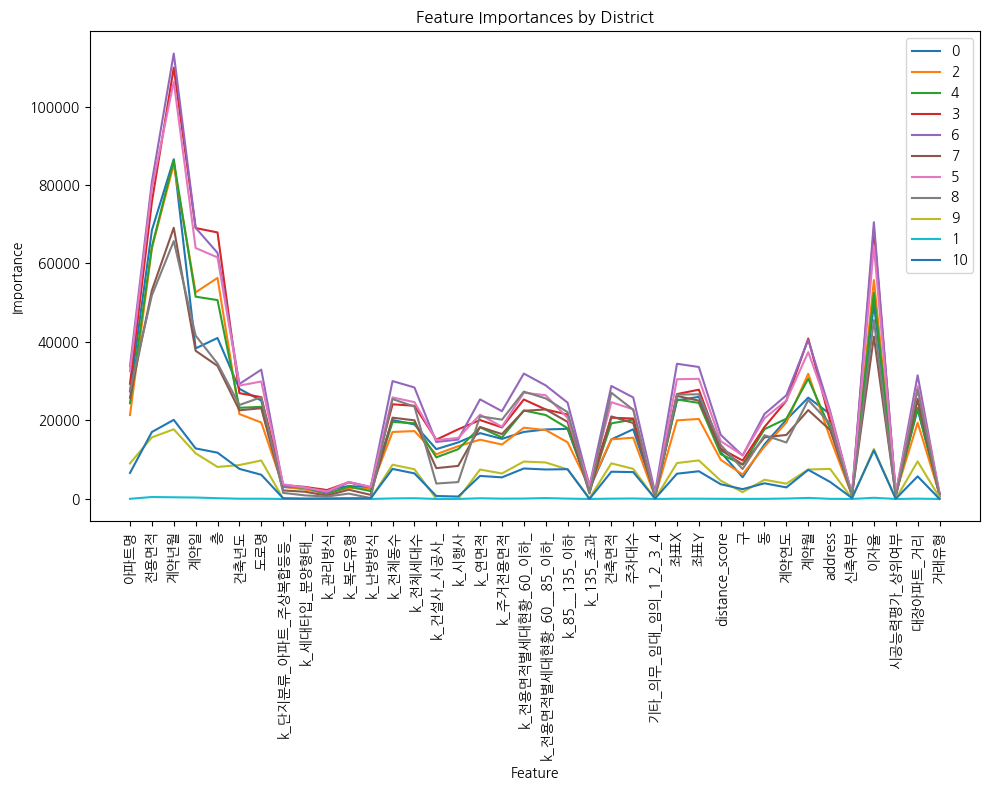

In [47]:
# 최종 예측 결과를 CSV 파일로 저장

if not final_predictions.empty:
    final_predictions = final_predictions.sort_values('id')
    final_predictions.to_csv('output.csv', index=False)
    print("Predictions saved to output.csv")
else:
    print("No predictions were made. Check your data.")
    
# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
for district in districts:
    district_importance = feature_importances[feature_importances['district'] == district]
    plt.plot(district_importance['feature'], district_importance['importance'], label=district)

plt.title('Feature Importances by District')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
# WandB 실행 종료